Compare SC from UNC and Raj lab

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Load data

In [5]:
import mat73
num_rois = 246
ui = np.triu_indices(num_rois, 1)
sc_mat1 = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"]
sc_mat2_raw = mat73.loadmat(DATA_ROOT/"avg_sc_100.mat")["mean_sc"];


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


In [6]:
lb1 = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv")["label"][:num_rois]
lb2 = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv")["L/R"][:num_rois];
sc_mat1_lb = np.array([f"{l1}_{l2}".lower() for l1, l2 in zip(lb1, lb2)]);
sc_mat2_lb = np.loadtxt(DATA_ROOT/"names.txt", dtype=str);
sc_mat2_lb0 = np.array([lb[3:].lower() for lb in sc_mat2_lb]);

# Pre-process

In [7]:
# Make the BN SC into our order (order from SC in rajlab)
# if ROI not included, I use -1
sc_mat2= np.zeros_like(sc_mat1) - 1;
for idx1, roi1 in enumerate(sc_mat1_lb):
    for idx2, roi2 in enumerate(sc_mat1_lb):
        if (roi1 not in sc_mat2_lb0) or (roi2 not in sc_mat2_lb0):
            continue
        else:
            lidx = np.where(roi1 == sc_mat2_lb0)[0][0]
            ridx = np.where(roi2 == sc_mat2_lb0)[0][0]
            sc_mat2[idx1, idx2] = sc_mat2_raw[lidx, ridx]

<AxesSubplot:title={'center':'UNC SC'}>

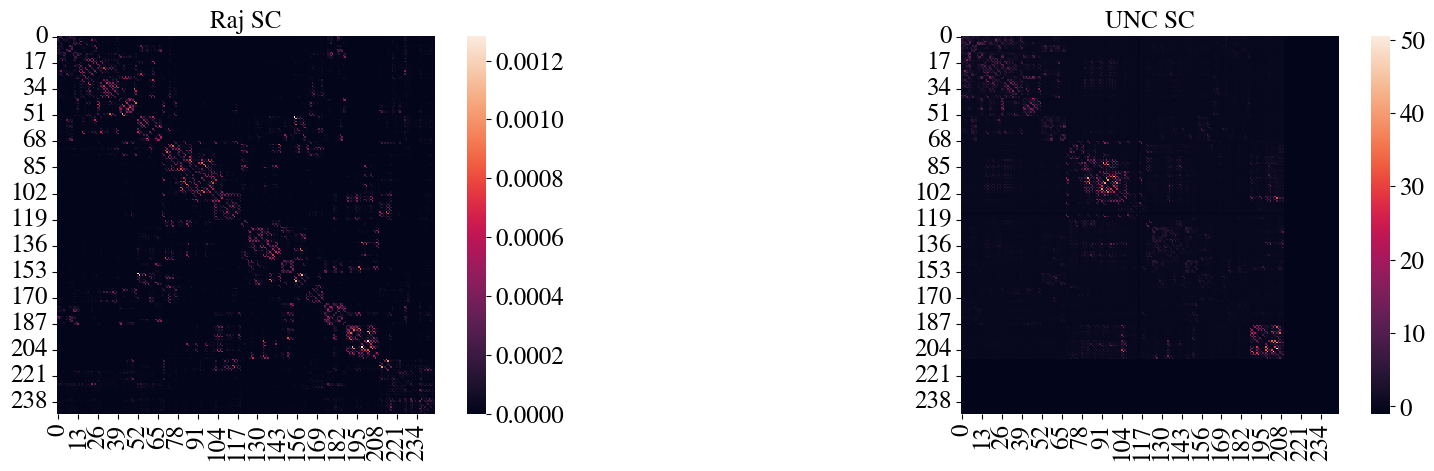

In [8]:
plt.figure(figsize=[20, 5])
plt.subplot(121)
plt.title("Raj SC")
sns.heatmap(sc_mat1, square=True)
plt.subplot(122)
plt.title("UNC SC")
sns.heatmap(sc_mat2, square=True)

# Raj SC is normalized by sum(abs(sc))
# Let remove other ROIs, and only keep 210

In [9]:
num_rois_part = 210
sc_mat1_part = sc_mat1[:num_rois_part, :num_rois_part]
sc_mat2_part = sc_mat2[:num_rois_part, :num_rois_part];
sc_mat2_part[sc_mat2_part < 0] = 0

sc_mat1_part = sc_mat1_part/np.sum(np.abs(sc_mat1_part));
sc_mat2_part = sc_mat2_part/np.sum(np.abs(sc_mat2_part));


In [12]:
from scipy.io import savemat
savemat(MIDRES_ROOT/"scs_210.mat", 
        { "raj_sc":sc_mat1_part, "unc_sc":sc_mat2_part}
       )

<AxesSubplot:title={'center':'UNC SC'}>

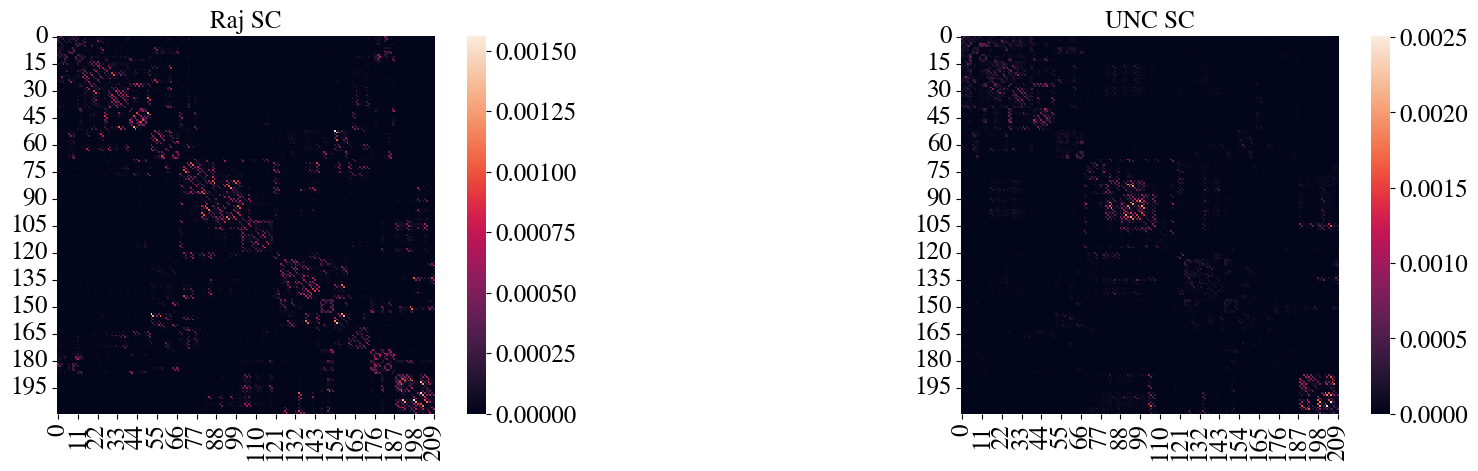

In [10]:
plt.figure(figsize=[20, 5])
plt.subplot(121)
plt.title("Raj SC")
sns.heatmap(sc_mat1_part, square=True)
plt.subplot(122)
plt.title("UNC SC")
sns.heatmap(sc_mat2_part, square=True)

# Get resutls for plot

In [11]:
def get_lap_eig(mat):
    Dmat_invhalffrac = np.diag(1/(mat.sum(axis=0)**0.5))
    mat_norm = Dmat_invhalffrac @ mat @ Dmat_invhalffrac
    mat_norm[np.isnan(mat_norm)]=0
    Lap_mat = np.eye(mat.shape[0]) - mat_norm
    # col is the eig vectors
    eigvals, eigvecs = np.linalg.eigh(Lap_mat); 
    sort_idx = np.argsort(np.abs(eigvals))
    eigvals, eigvecs = eigvals[sort_idx], eigvecs[:, sort_idx]
    return eigvals, eigvecs

In [12]:
eigval1, eigvec1 = get_lap_eig(sc_mat1_part)
eigval2, eigvec2 = get_lap_eig(sc_mat2_part);

/tmp/ipykernel_25638/24156056.py:2: RuntimeWarning: divide by zero encountered in true_divide
  Dmat_invhalffrac = np.diag(1/(mat.sum(axis=0)**0.5))


In [14]:
std_fn = lambda x: (x-x.min())/(x.max()-x.min())
for eig_ix in range(10):
    vec = eigvec1[:, eig_ix]
    vec_full = np.zeros(num_rois)
    vec_full[:num_rois_part] = std_fn(vec)
    np.savetxt(MIDRES_ROOT/f"rajsc_vec{eig_ix}_mm.txt", vec_full)
    
for eig_ix in range(10):
    vec = eigvec2[:, eig_ix]
    vec_full = np.zeros(num_rois)
    vec_full[:num_rois_part] = std_fn(vec)
    np.savetxt(MIDRES_ROOT/f"uncsc_vec{eig_ix}_mm.txt", vec_full)